# Cell 1: Load cleaned transactions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('../data/processed/fact_transactions.csv', parse_dates=['DATE'])
print(f"Loaded {len(df):,} transactions")

Loaded 2,595,696 transactions


# Cell 2: Calculate inter-purchase intervals

In [7]:
# Create a basket-level dataframe (drop duplicate days for the same household)
baskets = df[['household_key', 'DATE']].drop_duplicates().sort_values(['household_key', 'DATE'])

# Calculate days between VISITS (not items)
baskets['prev_date'] = baskets.groupby('household_key')['DATE'].shift(1)
baskets['days_between'] = (baskets['DATE'] - baskets['prev_date']).dt.days

# Drop NaNs (first visit) and filter out 0s if any remain (though drop_duplicates should handle it)
intervals = baskets['days_between'].dropna()
intervals = intervals[intervals > 0]  # Optional safety check

print(f"Calculated {len(intervals):,} inter-visit intervals")

Calculated 223,033 inter-visit intervals


# Cell 3: Statistical Summary

In [9]:
print("=== INTER-VISIT INTERVAL STATISTICS ===")
print(f"Mean:   {intervals.mean():.1f} days")
print(f"Median: {intervals.median():.1f} days")
print(f"Std:    {intervals.std():.1f} days")
print(f"Min:    {intervals.min():.0f} days")
print(f"Max:    {intervals.max():.0f} days")
print(f"\nPercentiles:")
for p in [25, 50, 75, 90, 95, 99]:
    print(f"  {p}th: {intervals.quantile(p/100):.1f} days")

=== INTER-VISIT INTERVAL STATISTICS ===
Mean:   6.9 days
Median: 3.0 days
Std:    15.9 days
Min:    1 days
Max:    666 days

Percentiles:
  25th: 2.0 days
  50th: 3.0 days
  75th: 7.0 days
  90th: 14.0 days
  95th: 22.0 days
  99th: 61.0 days


# Cell 4: Histogram

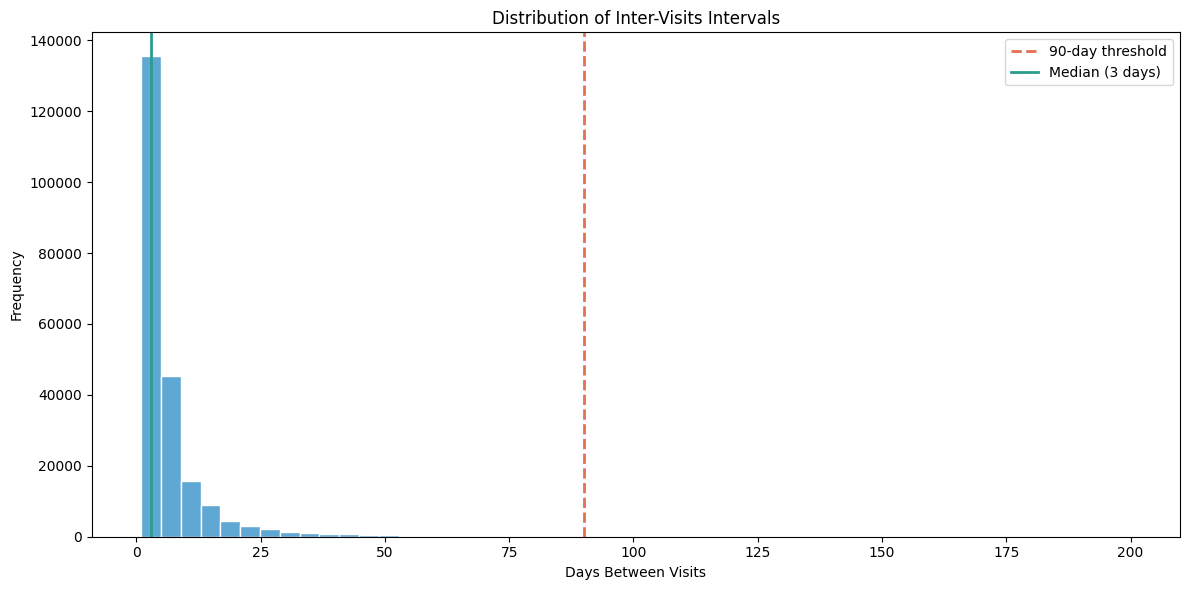

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(intervals[intervals <= 200], bins=50, edgecolor='white', color='#5FA8D3')
ax.axvline(x=90, color='#E76F51', linestyle='--', linewidth=2, label='90-day threshold')
ax.axvline(x=intervals.median(), color='#2A9D8F', linestyle='-', linewidth=2, label=f'Median ({intervals.median():.0f} days)')
ax.set_xlabel('Days Between Visits')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Inter-Visits Intervals')
ax.legend()
plt.tight_layout()
plt.savefig('../docs/assets/inter_visit_distribution.png', dpi=150)
plt.show()

# Cell 5: Threshold Evaluation

In [11]:
analysis_date = df['DATE'].max()

def evaluate_threshold(threshold):
    """Calculate metrics for a given churn threshold."""
    last_purchase = df.groupby('household_key')['DATE'].max()
    recency = (analysis_date - last_purchase).dt.days
    
    churned = (recency > threshold).sum()
    at_risk = ((recency > threshold - 30) & (recency <= threshold)).sum()
    active = (recency <= threshold - 30).sum()
    
    return {
        'threshold': threshold,
        'churned': churned,
        'churned_pct': churned / len(recency) * 100,
        'at_risk': at_risk,
        'active': active
    }

results = []
for t in [60, 75, 90, 105, 120]:
    results.append(evaluate_threshold(t))

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

 threshold  churned  churned_pct  at_risk  active
        60      255        10.20      199    2046
        75      203         8.12      137    2160
        90      171         6.84       84    2245
       105      145         5.80       58    2297
       120      120         4.80       51    2329


# Cell 6: Statistical Justification

In [13]:
median = intervals.median()
q1 = intervals.quantile(0.25)
q3 = intervals.quantile(0.75)
iqr = q3 - q1

upper_fence = q3 + 1.5 * iqr

print(f"Upper Fence (Statistical Break in Habit): {upper_fence:.1f} days")
print(f"Selected Threshold (Business Definition): 90 days")
print(f"Multiples of Median: 90 days is {90/median:.1f}x the typical shopping cycle.")
print("Conclusion: 90 days is a conservative threshold effectively isolating true churners from vacationers.")

Upper Fence (Statistical Break in Habit): 14.5 days
Selected Threshold (Business Definition): 90 days
Multiples of Median: 90 days is 30.0x the typical shopping cycle.
Conclusion: 90 days is a conservative threshold effectively isolating true churners from vacationers.
